In [1]:
# Author: Yuki Rivera
# This notebook contains code to evaluate the trained LSTM model

In [ ]:
from tensorflow.keras.models import Model,load_model
import pickle
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display
import matplotlib.pyplot as plt
import umap
from tensorflow.keras.layers import Dropout, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam


In [ ]:
perp_file_path = 'test_perplexity_rnn.txt'

Hyperparam

In [ ]:
# word_limit = 1000
vocab_size = 1000
enc_max_len = 64  # the prompt length
dec_max_len = 150   # the synopsis length

max_dec_input_length = dec_max_len - 1

max_generated_length = 50

embedding_dim = 128 # output_dim
units = 128

batch = 64
repeat = 20 # num of epochs
patience = 3 # early-stopping patience

val_ratio = 0.2 # validation set ratio

min_delta = 0.01

dropout_rate = 0.3
output_dim = 128

## Load the training history, the model and the tokenizer

In [ ]:
# Loads tokenizer
with open("tokenizer_LSTM.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Loads model
model = load_model("lstm_model.keras")

In [ ]:
start_token_id = tokenizer.word_index.get('<BOS>') 
end_token_id = tokenizer.word_index.get('<EOS>')   
oov_token_id = tokenizer.word_index.get('<OOV>')
pad_token_id = tokenizer.word_index.get('<PAD>')

## Get the testing data

In [ ]:
df = pd.read_csv('prompt_synopsis_test.csv')

In [ ]:
# pd.set_option('display.max_colwidth', None)
# testing_df.head(50)

### Select 20 pairs for testing

In [ ]:
testing_df = df.iloc[[20, 26, 64,84,88,98,106,111,127,164,190,199,225,231,242,244,259,298, 10597, 10609]]
testing_df = testing_df.reset_index(drop=True)

In [ ]:
# testing_df

In [ ]:
prompts = testing_df["prompt"].tolist()
references = testing_df["synopsis"].tolist()
tags_list = testing_df['tags_combined'].tolist()

### Defines the inference models (encoder and decoder separately)

In [ ]:
# Encoder

# Input: The raw token IDs of the prompt
encoder_inputs_inf = Input(shape=(enc_max_len,), name='encoder_input_inference')

# Get the Embedding layer from the trained model
encoder_embedding_inf_layer = model.get_layer('encoder_embedding')

# Get the LSTM layer from the trained model
encoder_lstm_layer = model.get_layer('encoder_lstm')

# Connect the input through the embedding layer first to get 3D tensor
encoder_embedding_output_inf = encoder_embedding_inf_layer(encoder_inputs_inf)

# Feed the 3D embedded input to the LSTM layer
# LSTM returns (sequence_output, last_h_state, last_c_state)
_, state_h_enc_inf, state_c_enc_inf = encoder_lstm_layer(encoder_embedding_output_inf)

# The encoder inference model outputs both final states
encoder_states_inf = [state_h_enc_inf, state_c_enc_inf]

encoder_model = Model(inputs=encoder_inputs_inf, outputs=encoder_states_inf)


In [ ]:
# Decoder 
# Inputs: A single token (the one just predicted or <BOS>) AND the previous decoder states.
decoder_input_single_token_inf = Input(shape=(1,), name='decoder_input_inference_token')

# Inputs for the previous decoder states (both h and c states for LSTM).
decoder_state_input_h_inf = Input(shape=(units,), name='decoder_state_input_h_inf')
decoder_state_input_c_inf = Input(shape=(units,), name='decoder_state_input_c_inf')
decoder_states_inputs_inf = [decoder_state_input_h_inf, decoder_state_input_c_inf]


# Get the relevant layers from the loaded training_model by their names.
decoder_embedding_inf_layer = model.get_layer('decoder_embedding')
decoder_lstm_inf_layer = model.get_layer('decoder_lstm') 
decoder_dense_inf_layer = model.get_layer('decoder_output')

# Connect the single token input to the decoder's embedding layer.
decoder_embedding_output_inf = decoder_embedding_inf_layer(decoder_input_single_token_inf)

# Connect the embedded token and previous states to the decoder LSTM layer.
# Pass the list of two states as initial_state
decoder_outputs_inf_sequence, state_h_dec_inf, state_c_dec_inf = decoder_lstm_inf_layer(
    decoder_embedding_output_inf, initial_state=decoder_states_inputs_inf
)

# Connect the decoder LSTM's sequence output to the final dense layer to get probabilities.
decoder_outputs_prob_inf = decoder_dense_inf_layer(decoder_outputs_inf_sequence)

decoder_model = Model(
    inputs=[decoder_input_single_token_inf] + decoder_states_inputs_inf, # All inputs: token + h state + c state
    outputs=[decoder_outputs_prob_inf, state_h_dec_inf, state_c_dec_inf] # All outputs: probabilities + new h state + new c state
)

### Preprocess the testing data

In [ ]:
def clean_text(text):
    return str(text).lower().strip()

In [ ]:
# Applies text cleaning
for col in ['prompt', 'synopsis']:
    testing_df[col] = testing_df[col].astype(str).apply(clean_text)

In [ ]:
# Converts text to sequences 
test_prompt_seqs = tokenizer.texts_to_sequences(testing_df['prompt'].tolist())
test_synopsis_seqs = tokenizer.texts_to_sequences(testing_df['synopsis'].tolist())

# Adds special tokens for decoder input/target
test_decoder_input_ids = [[start_token_id] + seq for seq in test_synopsis_seqs]
test_decoder_target_ids = [seq + [end_token_id] for seq in test_synopsis_seqs]

# Pads all sequences
X_enc_test = pad_sequences(test_prompt_seqs, maxlen=enc_max_len, padding='post', value=pad_token_id)
X_dec_test = pad_sequences(test_decoder_input_ids, maxlen=max_dec_input_length, padding='post', value=pad_token_id)

y_test = pad_sequences(test_decoder_target_ids, maxlen=max_dec_input_length, padding='post', value=pad_token_id)

# Reshapes target 
y_test = np.expand_dims(y_test, axis=-1)

### Calculates the test perplexity

In [ ]:
test_results = model.evaluate([X_enc_test, X_dec_test], y_test, verbose=0)

# Extracts the loss value 
test_loss = test_results[0] if isinstance(test_results, list) else test_results

# Calculate perplexity
test_perplexity = np.exp(test_loss)

print(f"Final LSTM Test Perplexity: {test_perplexity:.2f}")

Final LSTM Test Perplexity: 266.66


### Saves the perplexity to a text file

In [ ]:
with open('avg_perp_lstm.txt', 'w') as f:
    f.write(str(test_perplexity))

### Adds Temprature Sampling

In [ ]:
def sample_with_temperature(preds, temperature=0.7):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

### Function to generate synopsis

In [ ]:
def generate_synopsis(prompt, encoder_model, decoder_model, tokenizer, max_words=max_generated_length, temp=0.7):
    input_seq = tokenizer.texts_to_sequences([prompt])
    padded_input_seq = pad_sequences(input_seq, maxlen=enc_max_len, padding='post', truncating='post', value=pad_token_id)

    states_value = encoder_model.predict(padded_input_seq, verbose=0) 

    target_seq = np.zeros((1, 1), dtype='int32')
    target_seq[0, 0] = start_token_id

    stop_condition = False
    generated_synopsis_ids = []

    OOV_ID = tokenizer.word_index.get("<OOV>")

    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0) # Unpack h and c

        sampled_token_index = sample_with_temperature(output_tokens[0, 0, :], temperature=temp)

        generated_synopsis_ids.append(sampled_token_index)

        if sampled_token_index == end_token_id:
            stop_condition = True
        if len(generated_synopsis_ids) >= max_words:
            stop_condition = True

        target_seq = np.zeros((1, 1), dtype='int32')
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c] # Update states_value as a list for the next iteration

    generated_words = []

    for token_id in generated_synopsis_ids:
        if token_id == end_token_id: 
            break
        word = tokenizer.index_word.get(token_id)
        if word in {'<OOV>', '<PAD>'}:
            continue
        elif word is not None and token_id != start_token_id: 
            generated_words.append(word)

    generated_text = ' '.join(generated_words)
    return generated_text

### Generates synopsis, computes cosine similarity for each pair, prints the result

In [ ]:
def evaluate_outputs(model, tokenizer, prompts, references, tags_combined, enc_max_len, dec_max_len, print_count=10):

    # Loads the pre-trained model for creating sentence embeddings
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
    results = []

    for i in range(len(prompts)):
        # Gets all the data for the current row
        prompt = prompts[i]
        true_synopsis = references[i]
        tags = tags_combined[i]

        # Generates a new synopsis from the full prompt
        generated_synopsis = generate_synopsis(
            prompt=prompt, encoder_model=encoder_model, decoder_model=decoder_model,tokenizer=tokenizer, max_words=dec_max_len
        )


        # Creates embeddings for the tags and generated synopsis.
        emb_tags = embedding_model.encode(tags)
        emb_generated = embedding_model.encode(generated_synopsis)

        # Calculates the cosine similarity between the tags and the generated text.
        similarity = cosine_similarity([emb_tags], [emb_generated])[0][0]

        # Stores all relevant information in the results dictionary
        results.append({
            "tags_combined": tags,
            "prompt": prompt,
            "generated": generated_synopsis,
            "true_synopsis": true_synopsis, 
            "cosine_similarity": similarity
        })

        # Prints the first few results for manual inspection
        if i < print_count:
            print(f"\nPrompt {i+1}: {prompt}")
            print(f"Generated: {generated_synopsis}")
            print(f"True:      {true_synopsis}")
            print(f"Cosine Similarity: {similarity:.3f}")
            print("—" * 50)

    return results

In [ ]:
results = evaluate_outputs(model, tokenizer, prompts, references, tags_list, enc_max_len, dec_max_len)

Inside generate_synopsis — type of tokenizer: <class 'keras.src.legacy.preprocessing.text.Tokenizer'>

Prompt 1: Write an anime synopsis that matches 'Adventure, Comedy and Fantasy'.
Generated: a is a high problems of the young the school of the the like and when the of decides to find the
True:      on one noteworthy day in the adventurer's guild, kazuma satou encounters someone unexpecteda fan of his named ran. surprised that he even has a fan, kazuma attempts to play it cool to impress her. unfortunately for him, the guild's receptionist arrives with a request to defeat a giant golem guarding some ancient ruins, and kazuma accepts only to keep ran's admiration. upon kazuma and his party's successful return from the ruins, kazuma continues to shamelessly brag to ran. capitalizing on his desperation, the receptionist approaches him with another quest that requires him to return to the same ruins. hoping to find valuable treasures, kazuma once again convinces his party to join himbut t

### Computes the avg cosine similarity and saves it to a text file

In [ ]:
avg_similarity = sum(r["cosine_similarity"] for r in results) / len(results)
with open('avg_sim_lstm.txt', 'w') as f:
    f.write(str(avg_similarity))

### Saves all the results to a csv file

In [ ]:
df_results = pd.DataFrame(results)
df_results.to_csv("generated_results_with_similarity_calc.csv", index=False)

### Table for comparison

In [ ]:
# shows full text in cells
pd.set_option('display.max_colwidth', None)

# displays a table nicely

df_results.head(10).style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])


,tags_combined,prompt,generated,true_synopsis,cosine_similarity
0,adventure comedy fantasy,"Write an anime synopsis that matches 'Adventure, Comedy and Fantasy'.",a is a high problems of the young the school of the the like and when the of decides to find the,"on one noteworthy day in the adventurer's guild, kazuma satou encounters someone unexpecteda fan of his named ran. surprised that he even has a fan, kazuma attempts to play it cool to impress her. unfortunately for him, the guild's receptionist arrives with a request to defeat a giant golem guarding some ancient ruins, and kazuma accepts only to keep ran's admiration. upon kazuma and his party's successful return from the ruins, kazuma continues to shamelessly brag to ran. capitalizing on his desperation, the receptionist approaches him with another quest that requires him to return to the same ruins. hoping to find valuable treasures, kazuma once again convinces his party to join himbut this time, he may be biting off more than he can chew.",0.161820
1,mystery supernatural,Write an anime synopsis that matches 'Mystery and Supernatural'.,years and and the mysterious for the second girl named has is a mission to demon of the users he is granted the shadow is a train to the and the village of this fifteen over the,"the anime is set in the fictional geso ward in tokyo, a school city where an app called aicis is becoming popular. those who get the app are given supernatural powers, which they use to pursue their own selfish desires, leading to many occurrences of violence and other incidents. the story focuses on a group of detectives who solve cases related to power wielders.",0.420327
2,historical mythology shoujo,Generate a 'Historical and Mythology' themed anime targeting 'Shoujo'.,"the is a second clan, is a super as a of a the mysterious group of and the the of the","in the nineteenth century, we find lydia carlton living in scotland, making a living as a fairy doctor. she is one of those rare humans who can see and communicate with fairies. but no one believes her. however, edgar is in need of someone with a vast knowledge of fairy lore, and lydia is just that person. after rescuing her, he becomes her employer, but there are many secrets and emotions that seem to follow edgar, who claims to be the blue knight's earl.",0.248099
3,adventure,Write an anime synopsis that matches 'Adventure'.,recap of the anime student,"takashi loves reading books and especially loves alice's adventures in wonderland. one day, he buys some used books, and he finds one book thrown in. when takashi opens the book, the god of math m1 appeared. takashi is told that alice is kidnapped, and he's asked to rescue her by m1. and takashi goes on an adventure in wonderland to rescue alice.",0.151322
4,anthropomorphic comedy fantasy slice of life,"Create an anime synopsis with 'Comedy, Fantasy and Slice Of Life' and 'Anthropomorphic'.",,"in a city filled with anthropomorphic catpeople, catman lives free of rules and boundaries, doing everything he wants, which often collides with the other inhabitants of the city. created entirely in flash, with no spoken dialog, catman instead speaks in english and japanese subtitles. the series is spread across three socalled 'seasons', with only the third having been aired.",0.097399
5,action adventure drama romance sci-fi,"Write an anime synopsis that matches 'Action, Adventure, Drama, Romance and Sci-Fi'.",the series to participate our and a of the,"in the backwater town of bellforest lives a 14yearold boy named renton thurston. he desires to leave his home behind and join the mercenary group known as gekkostate, hoping to find some adventure to brighten up his mundane life. however, stuck between his grandfather's insistence to become a mechanic like him and the pressure of his deceased father's legacy, the only excitement renton finds is in his pastime of riding the trapar wave particles that are dispersed throughout the air, an activity akin to surfing. every

### Visualizing Tags vs Output Embeddings Scatter Plot Using UMAP

In [ ]:
# loads the embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


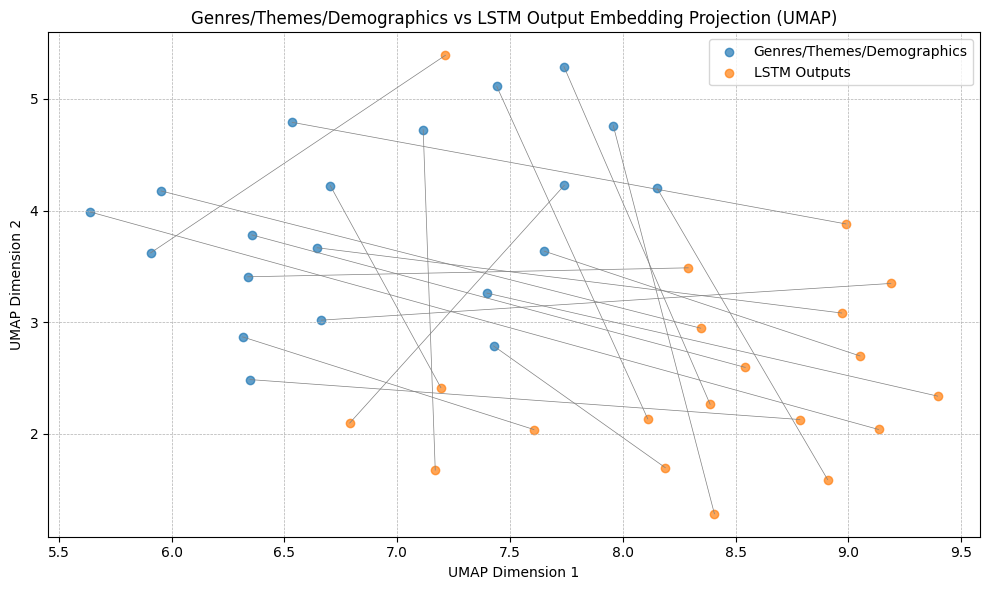

In [ ]:
# extracts the tags and generated synopsis from the results list
tags_to_match = [row["tags_combined"] for row in results]
generated_outputs = [row["generated"] for row in results]

# converts each prompt and generated output into a high-dim vector
tags_embeddings = embedding_model.encode(tags_to_match)
output_embeddings = embedding_model.encode(generated_outputs)

# combines both embeddings into a single array
all_embeddings = np.vstack([tags_embeddings, output_embeddings])

# reduces the dimension for visualization
reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(all_embeddings)

# splits embeddings into the tags and the output
n = len(tags_to_match)
umap_tags = umap_embeddings[:n]
umap_outputs = umap_embeddings[n:]

# plots a scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(umap_tags[:, 0], umap_tags[:, 1], label="Genres/Themes/Demographics", alpha=0.7)
plt.scatter(umap_outputs[:, 0], umap_outputs[:, 1], label="LSTM Outputs", alpha=0.7)

# draws light gray lines to show the differences between the tags vs output
for i in range(n):
    plt.plot([umap_tags[i, 0], umap_outputs[i, 0]],
             [umap_tags[i, 1], umap_outputs[i, 1]],
             c='gray', linewidth=0.5)

plt.title("Genres/Themes/Demographics vs LSTM Output Embedding Projection (UMAP)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig(
    'scatter_plot_lstm.png',
    dpi=300,
    bbox_inches='tight' 
)
plt.tight_layout()
plt.show()